In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
from fastai.imports import *
np.set_printoptions(linewidth=110)

In [4]:
comp = 'titanic'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [8]:
# ask yourself why we don't consider Pclass a categorical variable
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [10]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

# Binary Splits

### Splitting on a Categorical Column

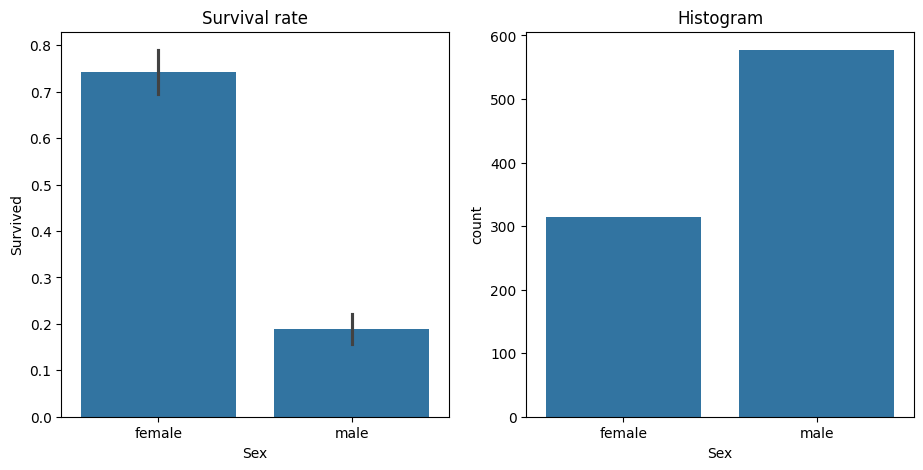

In [11]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [12]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats].head()

,Sex,Embarked
298,male,S
884,male,S
247,female,S
478,male,S
305,male,S


In [13]:
# transform the categories by their codes
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)
trn_df[cats].head()

,Sex,Embarked
298,1,2
884,1,2
247,0,2
478,1,2
305,1,2


In [14]:
def make_variables(df):
    x = df[cats+conts].copy()
    return x, df[dep] if dep in df else None

trn_x, trn_y = make_variables(trn_df)
val_x, val_y = make_variables(val_df)


In [15]:
# split point
# doesn't matter we don't kno what's the optimal value yet
preds = val_x.Sex == 1
preds

709     True
439     True
840     True
720    False
39     False
       ...  
880    False
425     True
101     True
199    False
424     True
Name: Sex, Length: 223, dtype: bool

In [16]:
from sklearn.metrics import mean_absolute_error

# measure accuracy
mean_absolute_error(val_y, preds)

0.7847533632286996

### Splitting on a Continuous column

<Axes: xlabel='LogFare', ylabel='Density'>

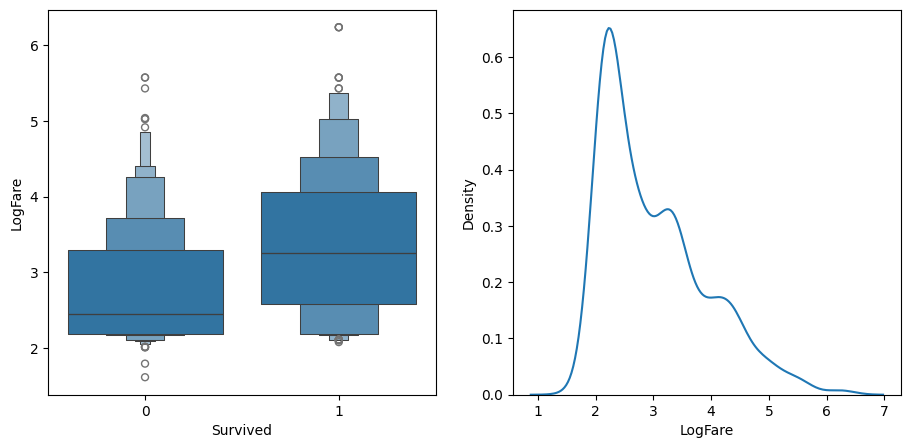

In [17]:
df_fare = trn_df[trn_df.LogFare>0]
fg,axs = plt.subplots(1, 2, figsize=(11,5))

# quartiles
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=axs[0])

# kernel density estimate 
# split the data in bins?
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])

In [18]:
# split point
# we want to split at the densiest place?
# according to the graph the most density is aroud 2.7
preds = val_x.LogFare>2.7

In [19]:
# measure accuracy
mean_absolute_error(val_y, preds)

0.336322869955157

### Finding the right threshold

How can we quickly experiment with different threshold?

What is a good split? We want a little tool that let us experiment
with different split and show us the score for each

But what's a definition of a good split?

> Think like separating oil from water, we want oil to be on one side and water to be on another side.

> And each side should be as pure as possible

> This purity can be defined by similarity (in statistisque similary is measured by std deviation)

> If we take a poin of referece (the avg) and we calculate the distance, we can now how similar they are from the average or how different they are

In [20]:
def similarity_score(group, y):
    total = group.sum()
    if total <= 1: return 0
    # why * total?
    return y[group].std() * total

def similartiy_score_for_split(col, y, threshold):
    left_half = col <= threshold
    left_score = similarity_score(left_half, y)
    right_score = similarity_score(~left_half, y)
    # take the average
    return (left_score + right_score) / len(y)

In [21]:
# checking the purity via standard deviation
# lower is better
similartiy_score_for_split(trn_x["Sex"], trn_y, 0.5)

0.4078753098206398

In [22]:
similartiy_score_for_split(trn_x["LogFare"], trn_y, 2.7)

0.4718087395209973

In [23]:
# use by scikitlearn to create random forests
# similar purpose as similartiy_score_for_split
# but different usage?
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [24]:
def iscore(nm, split):
    col = trn_x[nm]
    return similartiy_score_for_split(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [25]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

It's better than hardcoding a value, but we can automate this process further

In [26]:
# make a list of all possible split points (so all possible values)
nm = "Age"
col = trn_x[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  , 11.  , 12.  , 13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  ,
       23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  ,
       45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 56.  ,
       57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [27]:
# run similarity score with all the possible thresolds (values)
# and get that minimum std deviation (lower is better)
scores = np.array([similartiy_score_for_split(col, trn_y, o) for o in unq if not np.isnan(o)])
best_similarity_score = unq[scores.argmin()]
best_similarity_score


6.0

In [28]:
def find_best_split_for_best_similarity_for_column(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([similartiy_score_for_split(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

find_best_split_for_best_similarity_for_column(trn_df, "Age")

(6.0, 0.47831671750899085)

In [29]:
# now we can do that for all the columns
# and we sort by lowest std deviation (best similarity)

def find_splits_for_columns(cols, trn_df):
    splits = {o:find_best_split_for_best_similarity_for_column(trn_df, o) for o in cols}
    columns_with_best_split = sorted(splits.items(), key=lambda x: x[1][1])
    return columns_with_best_split

cols = cats+conts
find_splits_for_columns(cols, trn_df)

[('Sex', (0, 0.4078753098206398)),
 ('Pclass', (2, 0.46048261885806663)),
 ('LogFare', (2.4390808375825834, 0.4620823937736595)),
 ('Age', (6.0, 0.47831671750899085)),
 ('SibSp', (4, 0.4783740258817423)),
 ('Embarked', (0, 0.47883342573147897)),
 ('Parch', (0, 0.4805296527841601))]

According to this, Sex<=0 is the best split we can use.

We can now use that value to build a model that split sex column at 0
And verify the accuracy

In [30]:
preds = val_x.Sex == 0
mean_absolute_error(val_y, preds)

0.21524663677130046

So that's a OneR!

# From OneR to TwoR

Well we take the OneR and we divide even more
Meaning for each groups Male and Female, we find subgroups around using other feature

In [31]:
# create two groups according to the OneR
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]


In [32]:
# find the second column to split within the first group
# don't forget to remove this since it has been used
cols.remove('Sex')


In [33]:
find_splits_for_columns(cols, males)

[('Age', (6.0, 0.37398283710105873)),
 ('LogFare', (2.803360380906535, 0.38048562317581447)),
 ('Pclass', (1, 0.3815544200436083)),
 ('Parch', (0, 0.3874704821461953)),
 ('Embarked', (0, 0.387558187041091)),
 ('SibSp', (4, 0.38758642275862637))]

In [34]:
find_splits_for_columns(cols, females)

[('Pclass', (2, 0.3335388911567602)),
 ('LogFare', (4.256321678298823, 0.413505983329114)),
 ('Parch', (3, 0.4193314500446157)),
 ('Age', (50.0, 0.4225927658431646)),
 ('SibSp', (4, 0.42319212059713585)),
 ('Embarked', (0, 0.4295252982857326))]

The next best splits:
- for males is Age <= 6
- for females is Pclass <= 2

# Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_x, trn_y);

In [36]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

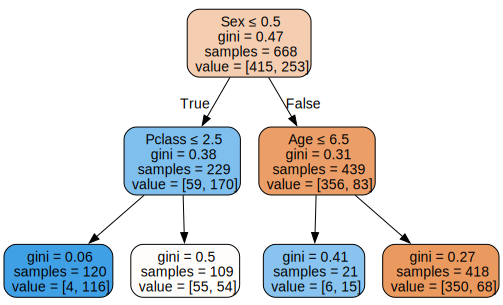

In [37]:
draw_tree(m, trn_x, size=10)

In [38]:
# let's check the accuracy of this model
# it's a bit worse, but let's try again with a bigger tree, more leaves
mean_absolute_error(val_y, m.predict(val_x))


0.2242152466367713

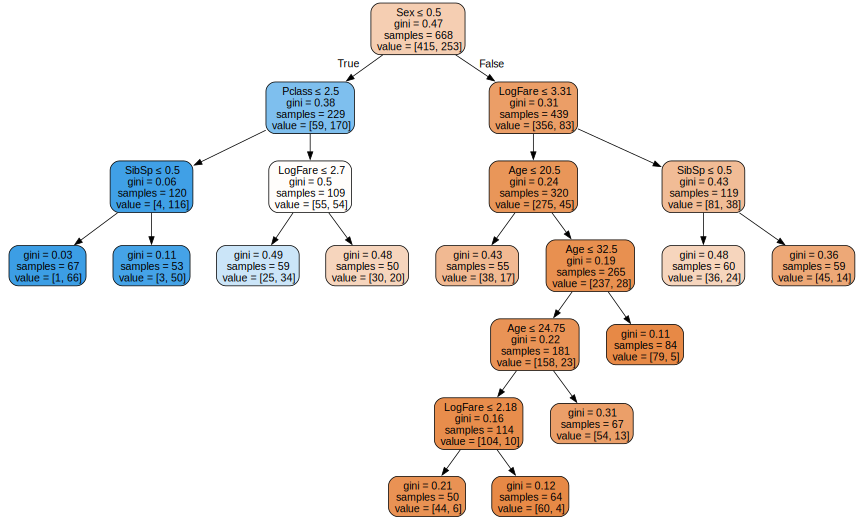

In [39]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_x, trn_y)
draw_tree(m, trn_x, size=12)


In [40]:
# let's check the accuracy of this model
# 0.18 better than our 0.225 OneR!
mean_absolute_error(val_y, m.predict(val_x))

0.18385650224215247

### Benefits of Random Forests

In [41]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = make_variables(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

https://www.kaggle.com/competitions/titanic/submissions


We got a score of 0.76 around the same a linear model, but it was muuuuch easier to do!


- no need of normalization
- categorification is easy
- easier than linear model, no need to think about bias or not bias term

# Random Forests

Looking at our previous tree, we already have some leaf nodes with less than 50rows, that's not a lot of data. So more leaves are not the solutions. But what's next then?

In [42]:
def create_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_x.iloc[idxs], trn_y.iloc[idxs])

In [43]:
trees = [create_tree() for t in range(100)]

In [44]:
# make each bag/model predict on the the validation/real set this time
all_probs = [t.predict(val_x) for t in trees]

# take their average
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

# it works because lots of ucnorrelated random errors is zero???!

0.22748878923766816

Taking a random subset of the training set is not good enough.

So we also pick a random subset of columns for each split

RandomForestClassifier will do it for us

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_x, trn_y);
mean_absolute_error(val_y, rf.predict(val_x))

0.18834080717488788

That's about the same as our single decision tree.
Yup, sometimes more is not better!

### Feature Importance

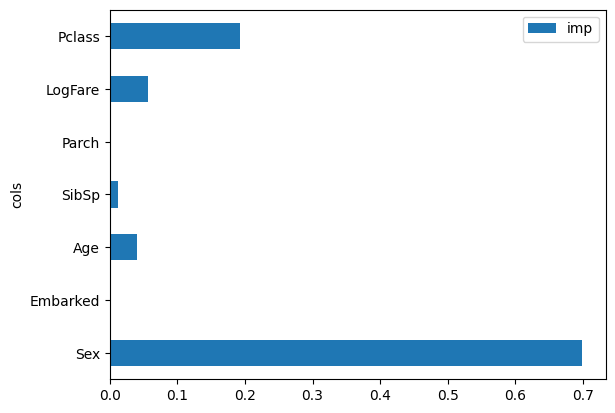

In [46]:

pd.DataFrame(dict(cols=trn_x.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [47]:
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)

ValueError: Source file not found: ./first-steps-road-to-the-top-part-1.ipynb